In [1]:
!git clone https://github.com/preddy5/segnet.git

fatal: destination path 'segnet' already exists and is not an empty directory.


In [27]:
!ls

Face-Recognition-data  model_weight_ep100.hdf5	sample_data  segnet


In [2]:

from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import itertools
import numpy as np
np.random.seed(1337) # for reproducibility

import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.layers import merge

from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import numpy as np

path = 'segnet/CamVid/'
data_shape = 360*480

Using TensorFlow backend.


In [4]:
!pip install imutils

  Running setup.py bdist_wheel for imutils ... - \ done
  Stored in directory: /root/.cache/pip/wheels/4c/ff/aa/824fb9efc5b8c740d54cd8bc19c7e85fbb8d115c77e56812c7
Successfully built imutils


In [5]:
!git clone https://github.com/mohanrajmit/Face-Recognition-data.git

Cloning into 'Face-Recognition-data'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [3]:
def normalized(rgb):
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=cv2.equalizeHist(b)
    norm[:,:,1]=cv2.equalizeHist(g)
    norm[:,:,2]=cv2.equalizeHist(r)

    return norm

def binarylab(labels):
    x = np.zeros([360,480,12])    
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]]=1
    return x

def prep_data():
    train_data = []
    train_label = []
    import os
    import numpy as np
    from imutils import paths
    with open('Face-Recognition-data/train1.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(len(txt)):
        ## these paths are very specific to my machine
        pa= txt[i][0][7:]
        filename = pa[pa.rfind("/") + 1:]
        
        path1=os.path.join("segnet","CamVid")
        path2=os.path.join(path1,pa.split("/")[-2])
        path3=os.path.join(path2,filename)
        
        pa1=txt[i][1][7:][:-1]
        filename1 = pa1[pa1.rfind("/") + 1:]
        
        path4=os.path.join("segnet","CamVid")
        path5=os.path.join(path4,pa1.split("/")[-2])
        path6=os.path.join(path5,filename1)
        
        
        
        #print(path3)
        #print(path6)
        #print(path)
        
        #path=os.path.join("segnet",pa)
        #print(os.path.join("segnet",pa))
        train_data.append(np.rollaxis(normalized(cv2.imread(path3)),2))
        train_label.append(binarylab(cv2.imread(path6)[:,:,0]))
        print('.',end='')
    return np.array(train_data), np.array(train_label)

train_data, train_label = prep_data()
train_label = np.reshape(train_label,(300,data_shape,12))
print(train_data.shape)

segnet/CamVid/train/0001TP_006690.png
segnet/CamVid/trainannot/0001TP_006690.png
.segnet/CamVid/train/0001TP_006720.png
segnet/CamVid/trainannot/0001TP_006720.png
.segnet/CamVid/train/0001TP_006750.png
segnet/CamVid/trainannot/0001TP_006750.png
.segnet/CamVid/train/0001TP_006780.png
segnet/CamVid/trainannot/0001TP_006780.png
.segnet/CamVid/train/0001TP_006810.png
segnet/CamVid/trainannot/0001TP_006810.png
.segnet/CamVid/train/0001TP_006840.png
segnet/CamVid/trainannot/0001TP_006840.png
.segnet/CamVid/train/0001TP_006870.png
segnet/CamVid/trainannot/0001TP_006870.png
.segnet/CamVid/train/0001TP_006900.png
segnet/CamVid/trainannot/0001TP_006900.png
.segnet/CamVid/train/0001TP_006930.png
segnet/CamVid/trainannot/0001TP_006930.png
.segnet/CamVid/train/0001TP_006960.png
segnet/CamVid/trainannot/0001TP_006960.png
.segnet/CamVid/train/0001TP_006990.png
segnet/CamVid/trainannot/0001TP_006990.png
.segnet/CamVid/train/0001TP_007020.png
segnet/CamVid/trainannot/0001TP_007020.png
.segnet/CamVid/tr

In [0]:

# class weigths
class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]


In [5]:
def create_encoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
        Activation('relu'),
    ]

def create_decoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return[
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, border_mode='valid'),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, border_mode='valid'),
        BatchNormalization(),
    ]


data_shape = 360*480


segnet_basic = models.Sequential()

segnet_basic.add(Layer(input_shape=(3, 360, 480)))



segnet_basic.encoding_layers = create_encoding_layers()
for l in segnet_basic.encoding_layers:
    segnet_basic.add(l)

# Note: it this looks weird, that is because of adding Each Layer using that for loop
# instead of re-writting mode.add(somelayer+params) everytime.

segnet_basic.decoding_layers = create_decoding_layers()
for l in segnet_basic.decoding_layers:
    segnet_basic.add(l)

segnet_basic.add(Convolution2D(12, 1, 1, border_mode='valid',))

segnet_basic.add(Reshape((12,data_shape), input_shape=(12,360,480)))
segnet_basic.add(Permute((2, 1)))
segnet_basic.add(Activation('softmax'))
segnet_basic.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=["accuracy"])

#from keras.optimizers import SGD
#optimizer = SGD(lr=0.01, momentum=0.8, decay=0., nesterov=False)
#autoencoder.compile(loss="categorical_crossentropy", optimizer='adadelta')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/usr/local/lib/pyt



```
# This is formatted as code
```

Visualizing segnet model architecture


In [65]:
!apt-get install graphviz
!pip install graphviz==0.5.2
!pip install pydot-ng==1.0.0


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
  Using cached https://files.pythonhosted.org/packages/c2/46/fab473f54ffbb932d191ca96a71a5d4f900b480526466e96e1c0069e7dac/graphviz-0.5.2-py2.py3-none-any.whl


In [60]:
!pip3 install pydot-ng
!pip3 install graphviz

In [66]:
from keras.utils import plot_model
from IPython.display import SVG

#SVG(plot_model(segnet_basic, show_shapes=True).create(prog='dot', format="svg"))
plot_model(segnet_basic, to_file="segnet.png", show_shapes=True)

ImportError: ignored

In [26]:
nb_epoch = 100
batch_size = 10

history = segnet_basic.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch,verbose=1, class_weight=class_weighting )
segnet_basic.save_weights('model_weight_ep100.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1]) 

Epoch 1/100
300/300 [==============================] - 79s 264ms/step - loss: 2.0342 - acc: 0.3655
Epoch 2/100
300/300 [==============================] - 61s 202ms/step - loss: 1.5725 - acc: 0.4890
Epoch 3/100
300/300 [==============================] - 61s 203ms/step - loss: 1.4576 - acc: 0.5311
Epoch 4/100
300/300 [==============================] - 61s 202ms/step - loss: 1.3441 - acc: 0.5683
Epoch 5/100
300/300 [==============================] - 61s 203ms/step - loss: 1.3188 - acc: 0.5754
Epoch 6/100
300/300 [==============================] - 61s 202ms/step - loss: 1.2606 - acc: 0.5873
Epoch 7/100
300/300 [==============================] - 61s 202ms/step - loss: 1.1660 - acc: 0.6218
Epoch 8/100
300/300 [==============================] - 61s 202ms/step - loss: 1.1837 - acc: 0.6126
Epoch 9/100
300/300 [==============================] - 61s 203ms/step - loss: 1.1473 - acc: 0.6253
Epoch 10/100
300/300 [==============================] - 61s 202ms/step - loss: 1.0927 - acc: 0.6408
Epoch 11/

### Visualization
I trained autoencoder sepeartely with 100 epochs, loading weights here.

In [0]:
segnet_basic.load_weights('model_weight_ep100.hdf5')

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

In [0]:
import os

gt = []
with open('Face-Recognition-data/train1.txt') as f:
    txt = f.readlines()
    txt = [line.split(' ') for line in txt]
for i in range(len(txt)):
    pa= txt[i][0][7:]
    filename3 = pa[pa.rfind("/") + 1:]
    path11=os.path.join("segnet","CamVid")
    path22=os.path.join(path11,pa.split("/")[-2])
    path33=os.path.join(path22,filename3)
    gt.append(cv2.imread(path33))

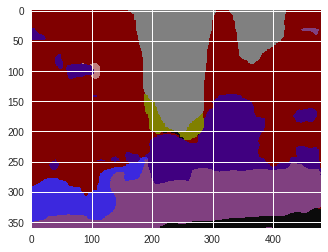

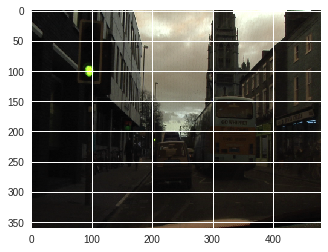

In [35]:
output = segnet_basic.predict_proba(train_data[2:3])
pred = visualize(np.argmax(output[0],axis=1).reshape((360,480)), False)
plt.imshow(pred)
plt.figure(2)
plt.imshow(gt[2])